### Convolution as Matrix-Vector Multiplication

In [5]:
import numpy as np

def im2col_loop(image, kernel_size, stride=1):
    bsz, ch, ih, iw = image.shape
    kh, kw = kernel_size
    oh, ow = (ih - kh) // stride + 1, (iw - kw) // stride + 1
    output = np.zeros([ch * kh * kw, oh * ow, bsz], dtype=image.dtype)
    
    for oi in range(oh):
        for oj in range(ow):
            ii, ij = oi * stride, oj * stride
            subimage = image[:, :, ii: ii + kh, ij: ij + kw]
            output[:, oi * oh + oj, :] = subimage.transpose(1, 2, 3, 0).reshape(ch * kh * kw, bsz)
    return output.reshape(ch * kh * kw, oh * ow * bsz)


def im2col_broadcast(image, kernel_size, stride=1):
    bsz, ch, ih, iw = image.shape
    kh, kw = kernel_size
    oh, ow = (ih - kh) // stride + 1, (iw - kw) // stride + 1
    base_idx = np.arange(kh).reshape(-1, 1) * iw + np.arange(kw)
    offset_idx = np.arange(oh).reshape(-1, 1) * iw * stride + np.arange(ow) * stride
    hw_idx = base_idx.reshape(-1, 1, 1) + offset_idx.reshape(-1, 1)
    idx = np.arange(ch).reshape(-1, 1, 1, 1) * ih * iw + np.arange(bsz) * ch * ih * iw + hw_idx
    return image.take(idx).reshape(ch * kh * kw, oh * ow * bsz)


def im2col_strided(image, kernel_size, stride=1):
    bsz, ch, ih, iw = image.shape
    kh, kw = kernel_size
    oh, ow = (ih - kh) // stride + 1, (iw - kw) // stride + 1
    shape = (ch, kh, kw, oh, ow, bsz)
    sb, sc, sh, sw = image.strides
    strides=(sc, sh, sw, sh * stride, sw * stride, sb)
    output = np.lib.stride_tricks.as_strided(image, shape=shape, strides=strides)
    return output.reshape(ch * kh * kw, oh * ow * bsz)


image = np.random.randint(low=0, high=255, size=(32, 3, 512, 512))
%timeit im2col_loop(image, kernel_size=(8, 8), stride=2)
%timeit im2col_broadcast(image, kernel_size=(8, 8), stride=2)
%timeit im2col_strided(image, kernel_size=(8, 8), stride=2)

3.64 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.98 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.2 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


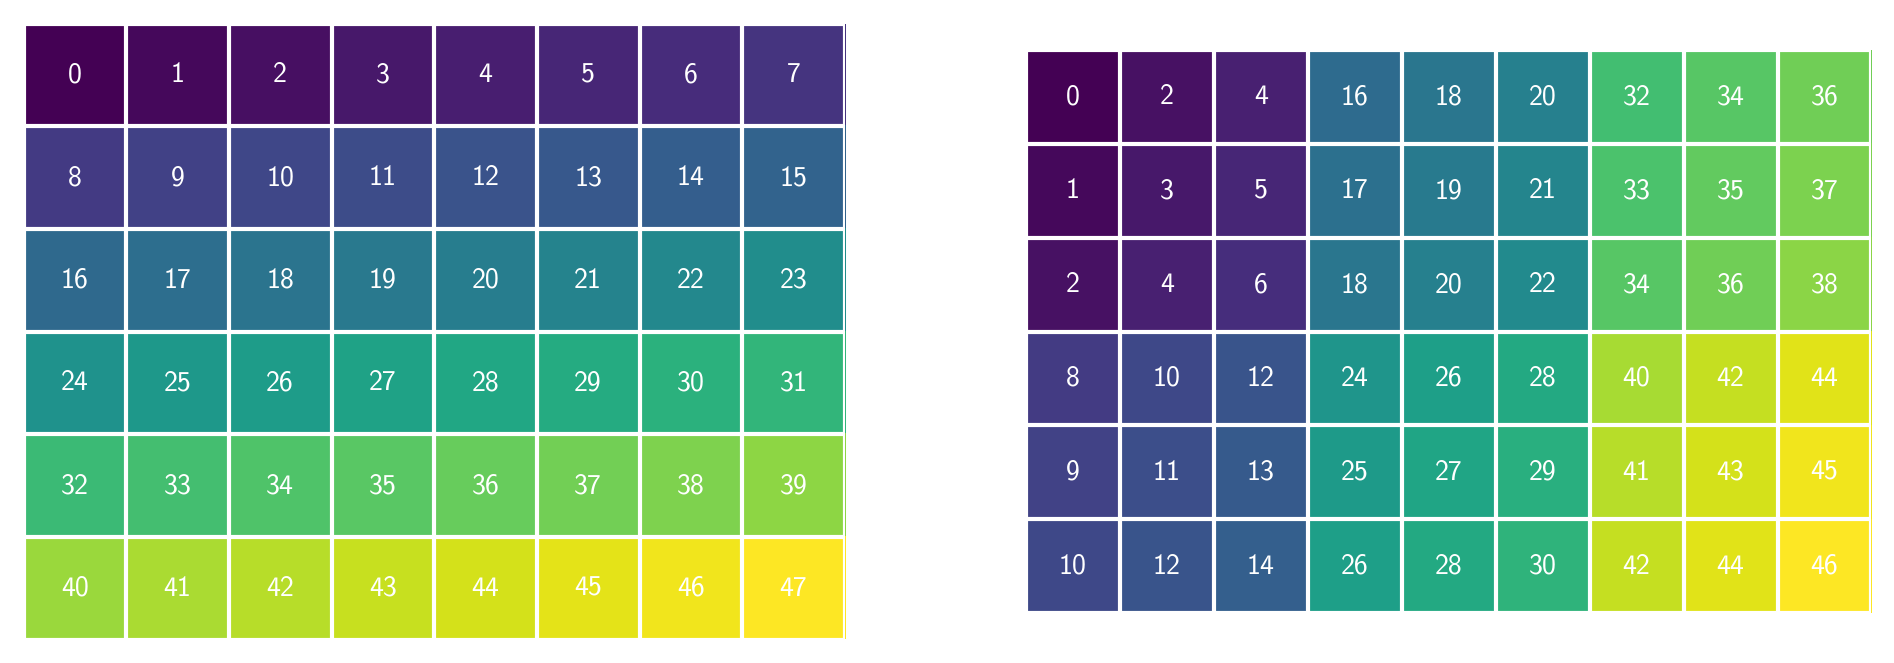

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plot_array(arr, ax):
    ax.imshow(arr, extent=(0, arr.shape[1], arr.shape[0], 0))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, arr[i, j], ha="center", va="center", color='w')
    
    ax.grid(color='w', linewidth=1.5)
    ax.set_frame_on(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

image = np.arange(48).reshape(1, 1, 6, 8)
columns = im2col_strided(image, kernel_size=(2, 3), stride=2)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_array(image[0, 0], axes[0])
plot_array(columns, axes[1])

In [6]:
import numpy as np
import torch
import torch.nn.functional as F

def conv2d(image, weight, stride=1):
    bsz, ich, ih, iw = image.shape
    och, ich, kh, kw = weight.shape
    oh, ow = (ih - kh) // stride + 1, (iw - kw) // stride + 1
    output = weight.reshape(och, -1) @ im2col_strided(image, kernel_size=(kh, kw), stride=stride)
    return output.reshape(och, oh, ow, bsz).transpose(3, 0, 1, 2)

image = torch.randn(32, 3, 224, 224)
weight = torch.randn(64, 3, 7, 7)
%timeit F.conv2d(image, weight, stride=2).numpy()
%timeit conv2d(image.numpy(), weight.numpy(), stride=2)
assert np.allclose(F.conv2d(image, weight, stride=2).numpy(), conv2d(image.numpy(), weight.numpy(), stride=2), atol=5e-5)

115 ms ± 9.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
269 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For a batch of images of size $N \times C_{\text{in}} \times H_{\text{in}} \times W_{\text{in}}$, a convolutional layer with weights of size $C_{\text{out}} \times C_{\text{in}} \times h \times w$ returns an output of size $N \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}$ where
\\[ H_{\text{out}} = \frac{H_{\text{in}} + 2P_H - h}{S_H} + 1, \qquad W_{\text{out}} = \frac{W_{\text{in}} + 2P_W - w}{S_W} + 1 \\]
and $P_H, P_W$ and $S_H, S_W$ denote the amounts of padding applied to the inputs and the strides of the convolution, respectively. It's simply because the top left corner of the sliding window has height and width index following the arithmetic sequences $0, \ S_H, \ 2S_H, \ \dots, (H_{\text{out}} - 1)S_H\ $ and $\ 0, \ S_W, \ 2S_W, \ \dots, (W_{\text{out}} - 1)S_W$.
* Same padding: $S_H = S_W = 1$ and $P_H = (h - 1) / 2$ and $P_W = (w - 1) / 2$ imply that $H_{\text{out}} = H_{\text{in}}$ and $W_{\text{out}} = W_{\text{in}}$.
* Full padding: $S_H = S_W = 1$ and $P_H = (h - 1)$ and $P_W = (w - 1)$ imply that $H_{\text{out}} = H_{\text{in}} + (h - 1)$ and $W_{\text{out}} = W_{\text{in}} + (w - 1)$.

### Transposed Convolution

Normally, a convolution layer reduces the resolution of an image unless excessive padding is applied. In some cases such as image generation, we actually want to do the reverse, which is to increase the resolution of an image. The idea is to also leverage convolution, but this time with lots of input padding. A transposed convolutional layer with no input padding is equivalent to a convolutional with full padding, where the weights of the latter is transposed (using the first two dimensions) and flipped (using the last two dimensions) to get those of the former.

For a batch of images of size $N \times C_{\text{in}} \times H_{\text{in}} \times W_{\text{in}}$, a transposed convolutional layer with weights of size $C_{\text{in}} \times C_{\text{out}} \times h \times w$ returns an output of size $N \times C_{\text{out}} \times H_{\text{out}} \times W_{\text{out}}$ where
\\[ H_{\text{out}} = (H_{\text{in}} - 1) \times S_H - 2P_H + h, \qquad W_{\text{out}} = (W_{\text{out}} - 1) \times S_W - 2P_W + w. \\]
and as before, $P_H, \ P_W$ and and $S_H, S_W$ denote the amounts of input padding and the strides of the convolution, respectively. When $S_H = S_W = 1$, this transposed convolutional layer is equivalent to a convolutional layer with weights of size $C_{\text{out}} \times C_{\text{in}} \times h \times w$ and input padding $(h - 1) - P_H, \ (w - 1) - P_W$.

In [59]:
import torch
import torch.nn.functional as F

input = torch.randn(32, 3, 28, 28)
weight = torch.randn(3, 64, 7, 7)
out1 = F.conv_transpose2d(input, weight)
out2 = F.conv2d(input, weight.transpose(0, 1).flip(2, 3), padding=6)
assert torch.allclose(out1, out2, atol=5e-5) 

In [1]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())